In [32]:
import uuid

import numpy as np
import keras
import chess

from src.search.db import MilvusVectorStore
from src.training.sample_generator import AutoencoderDataGenerator
from src.preprocessing.board_representation import (
    token_sequence_to_board,
    board_to_bitboard,
    bitboard_to_board,
    board_to_token_sequence,
    boolean_to_byte_vector,
    byte_to_boolean_vector
)

In [2]:
POSITION_DATA_PATH = "../data/test"
AUTOENCODER_MODEL_PATH = "../model/20231016214738_autoencoder.tf"
BATCH_SIZE = 100
BITBOARD_SIZE = 776
# this should be inferred from the model itself
EMBEDDING_SIZE = 256

In [3]:
position_generator = AutoencoderDataGenerator(POSITION_DATA_PATH, batch_size=BATCH_SIZE)
autoencoder: keras.Model = keras.models.load_model(AUTOENCODER_MODEL_PATH)
position_encoder = autoencoder.get_layer('encoder')
bitboard_vector_store = MilvusVectorStore(
    embedding_dimensions=BITBOARD_SIZE,
    embedding_type="binary",
    collection_name="bitboard"
)
embedding_vector_store = MilvusVectorStore(
    embedding_dimensions=EMBEDDING_SIZE,
    embedding_type="float",
    collection_name="embedding"
)

Connected to Milvus
Collection 'bitboard' deleted.
Collection 'bitboard' created.
Connected to Milvus
Collection 'embedding' deleted.
Collection 'embedding' created.


In [5]:
num_batches = 1
while not position_generator.all_data_seen:
    for position_batch, _ in position_generator:
        if position_batch is None:
            break
        # prepare id
        ids = [uuid.uuid1().int>>64 for _ in range(BATCH_SIZE)]

        # prepare bitboard
        boards = [token_sequence_to_board(position) for position in position_batch]
        bitboards = np.array([board_to_bitboard(board) for board in boards])
        padded_bitboards = np.pad(bitboards, ((0,0),(0,3)), mode="constant")
        byte_vector = boolean_to_byte_vector(padded_bitboards)

        # prepare embedding
        embedding_batch = position_encoder.predict_on_batch(position_batch)
        
        # store
        try:
            bitboard_vector_store.insert_embeddings([ids, byte_vector])
            embedding_vector_store.insert_embeddings([ids, embedding_batch.tolist()])
            print(f"Stored {num_batches*BATCH_SIZE} chess positions.", end="\r")
        except Exception as exc:
            print(len(byte_vector))
            print(byte_vector)
            print(embedding_batch.shape)
            print(embedding_batch)
            raise exc
        num_batches += 1
    position_generator.on_epoch_end()

RPC error: [batch_insert], <DataNotMatchException: (code=1, message=The Input data type is inconsistent with defined schema, please check it.)>, <Time:{'RPC start': '2024-04-01 12:49:23.296942', 'RPC error': '2024-04-01 12:49:23.297121'}>


100
[b'\x00\xc4\x08\x10\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x01\x00\x08\x00\x00\x00\x00\x80\x00\x02\x00\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x81"D\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x02\x80', b'\x00\xc4\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x02\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80 @\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x84\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00', b'\x00\xc2$\t\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x11\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00A\x12\x8c\x00\x00\x00\

DataNotMatchException: <DataNotMatchException: (code=1, message=The Input data type is inconsistent with defined schema, please check it.)>

# Now do similarity search

In [8]:
bitboard_vector_store.create_default_index()
embedding_vector_store.create_default_index()

Index embedding_BIN_IVF_FLAT_HAMMING on embedding created.
Index embedding_IVF_FLAT_L2 on embedding created.


In [75]:
top_k = 3
search_board = chess.Board("2kr4/pp1q3r/4ppp1/2p1b2p/3pP1n1/1P1P1QPN/P1P2P1P/R1B1R1K1 w - - 2 18")
search_bitboard = np.pad(board_to_bitboard(search_board), (0,3), mode="constant").reshape(1,776)
search_byte_vector = boolean_to_byte_vector(search_bitboard)
search_encoding = board_to_token_sequence(search_board)
search_embedding = position_encoder.predict(search_encoding.reshape((1,69)))

1/1 [==============================] - 0s 17ms/step


## Bitboard search

In [76]:
bitboard_search_result = bitboard_vector_store.search_by_embeddings(search_byte_vector, top_k=top_k)
bitboard_search_result

['["id: 8298712182449050094, distance: 22.0, entity: {\'id\': 8298712182449050094, \'embedding\': b\'\\\\x00\\\\x87`\\\\x10\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x08\\\\x00\\\\x10\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x10\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x02\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00!\\\\x0e\\\\xc0\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x18\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x10\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x02\\\\x00\\\\x80\'}", "id: 2964315229759279598, distance: 23.0, entity: {\'id\': 2964315229759279598, \'embedding\': b\'\\\\x00\\\\xa1R\\\\x08\\\\x04\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00\\\\x00 \\\\x00\\\\x00\\\\x00

query board:


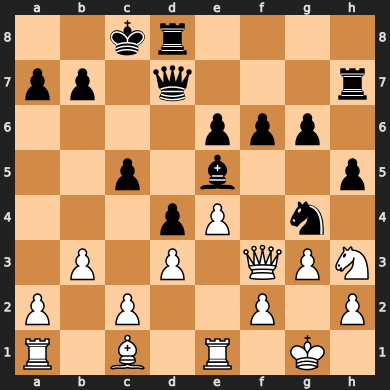

result_boards:


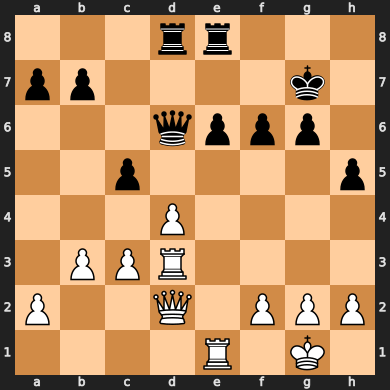

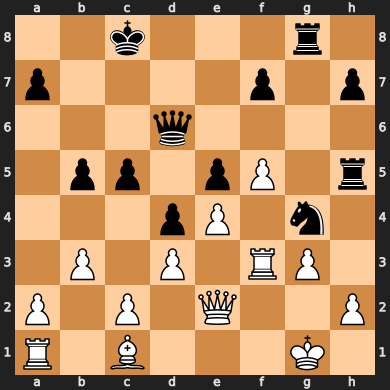

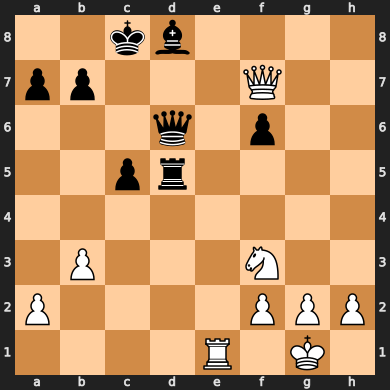

In [77]:
byte_results = [bitboard_search_result[0][i].fields["embedding"] for i in range(top_k)]
padded_bitboards = [byte_to_boolean_vector(byte_vector, (776,)) for byte_vector in byte_results]
bitboards = [vec[:773] for vec in padded_bitboards]
boards = [bitboard_to_board(bitboard) for bitboard in bitboards]
print("query board:")
display(search_board)
print("result_boards:")
for board in boards:
    display(board)

## Embedding search

In [78]:
embedding_search_results = embedding_vector_store.search_by_embeddings(search_embedding.tolist())
embedding_search_results

['["id: 9148535980961370606, distance: 44.52200698852539, entity: {\'id\': 9148535980961370606, \'embedding\': [-0.1994054615497589, -0.20656369626522064, -0.43050825595855713, 0.5465800166130066, -0.0992785096168518, -0.5274526476860046, 0.2868026793003082, 0.3951474130153656, -0.043715301901102066, 0.6875151991844177, 0.08374956250190735, 0.5274786353111267, -0.5333977937698364, -0.3655283451080322, -0.09084814786911011, -0.31916695833206177, -0.0018729777075350285, 0.3244051933288574, -0.4008741080760956, 0.17043618857860565, -0.0650157704949379, -0.22615034878253937, -0.36371681094169617, 0.12110850214958191, -0.6381129026412964, 0.2973586916923523, 0.22737404704093933, -0.017274055629968643, -0.32048845291137695, 0.06068302318453789, 0.042954228818416595, 0.7110701203346252, -0.048700347542762756, -0.11374609172344208, 0.2120596021413803, -0.5796981453895569, -0.44169461727142334, -0.45208272337913513, -0.0864710733294487, -0.6309666037559509, 0.008358835242688656, 0.3107188940048

In [79]:
embedding_ids = [embedding_search_results[0][i].fields["id"] for i in range(top_k)]
byte_vectors_search_results = bitboard_vector_store.search_by_ids(embedding_ids)
byte_vectors = [result["embedding"] for result in byte_vectors_search_results]
byte_vectors

[[b'\x00\xe7\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x88\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x08\xe3\x00\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x11\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x80'],
 [b'\x00\xe2\x11\x0c\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10%(\x82\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x11\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00 \x80'],
 [b'\x00\xe1\x10\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x02\x00\x00\x00\x00\x00\x00\x84\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x12(\x04\xc0\x00\x00

query board:


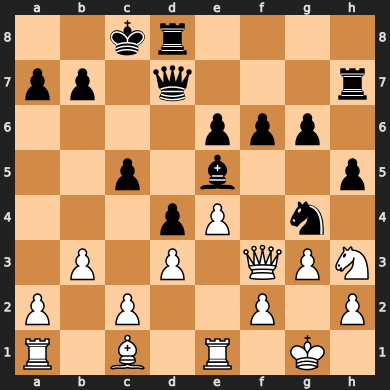

result_boards:


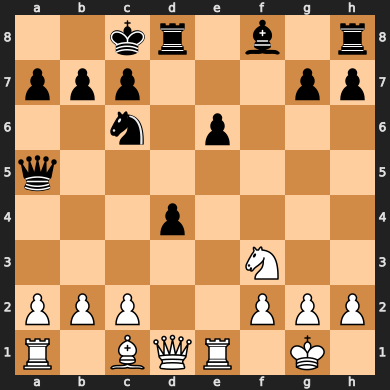

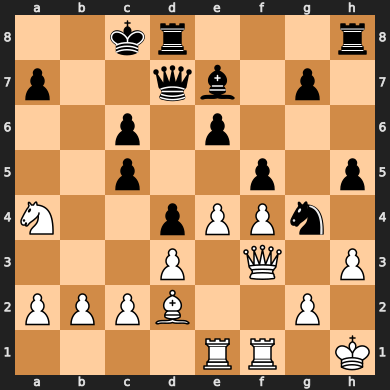

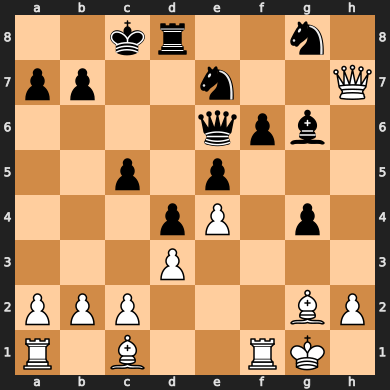

In [80]:
padded_bitboards = [byte_to_boolean_vector(byte_vector[0], (776,)) for byte_vector in byte_vectors]
bitboards = [vec[:773] for vec in padded_bitboards]
boards = [bitboard_to_board(bitboard) for bitboard in bitboards]
print("query board:")
display(search_board)
print("result_boards:")
for board in boards:
    display(board)